In [46]:
import os
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

import pykoopman as pk

In [47]:
pk.__version__

'1.0.8'

In [48]:
## Initialize/Load Sphero

Xfull = np.load("data/Xfull_5.npy")
Xfull = Xfull[:, 1000:1100, :]


N_x, N_u, N_d = 7, 4, 0

X0 = Xfull[:N_x, :, :]
X1 = Xfull[:-N_x, :, :]
U = Xfull[: N_x + N_u, :, :]

th = 0.010517
t0, tf = 0.0, th * (Xfull.shape[1])
t_arr = np.arange(t0, tf, th)
print(Xfull.shape, t_arr.shape)
n_T, N_T = 30, Xfull.shape[1]  # Number of sample trajectories, Length of ea. Trajectory

(18, 100, 1) (100,)


In [49]:
N_T

100

In [50]:
train_p = 0.6
idxs = np.arange(Xfull.shape[2])
np.random.shuffle(idxs)
# x_shuffled = x[idxs] how do i fix this line

# num_train_samples = int(Xfull.shape[2] * (train_p))
num_train_samples = 1
X_train_i = idxs[:num_train_samples]
X_test_i = idxs[num_train_samples:]

In [51]:
def plot_comparison(model, train_ix, no_comp=False, EDMDc=True):

    n_columns = 8  # Define the number of columns you want
    n_rows = (
        n_T * 4 + n_columns - 1
    ) // n_columns  # Calculate the number of rows needed

    plt.figure(figsize=(15 * n_columns, 8 * n_rows))
    N_T = 20
    t_arr = np.arange(t0, tf, th)[:N_T]

    for i in range(1):
        X = Xfull[:, :N_T, i]

        if np.isnan(X[:N_x, 0].T).any() or np.isnan(X[N_x : N_x + N_u, :].T).any():
            print(X[:N_x, 0].T.shape)
            print(X[N_x : N_x + N_u, :].T.shape)
            print("nan")
            return

        # Calculate positions for the subplots
        pos1 = i * 4 % (n_rows * n_columns) + 1
        pos2 = (i * 4 + 1) % (n_rows * n_columns) + 1
        pos3 = (i * 4 + 2) % (n_rows * n_columns) + 1
        pos4 = (i * 4 + 3) % (n_rows * n_columns) + 1

        ax1 = plt.subplot(n_rows, n_columns, pos1)
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")
        ax1.plot(X[0, :], X[1, :], alpha=0.8, label="Nominal", color="blue")

        ax2 = plt.subplot(n_rows, n_columns, pos2)
        ax2.set_xlabel("t")
        ax2.set_ylabel("X")
        ax2.plot(t_arr, X[0, :], alpha=0.8, label="Nominal", color="blue")

        ax3 = plt.subplot(n_rows, n_columns, pos3)
        ax3.set_xlabel("t")
        ax3.set_ylabel("Y")
        ax3.plot(t_arr, X[1, :], alpha=0.8, label="Nominal", color="blue")

        ax4 = plt.subplot(n_rows, n_columns, pos4)
        ax4.set_xlabel("t")
        ax4.set_ylabel("Error")

        if not (no_comp):
            if not (EDMDc):
                Xhp = model.simulate(
                    X[:N_x, 0].T, X[N_x : N_x + N_u, :].T, n_steps=N_T - 1
                )
                Xh = np.vstack((X[:N_x, 0].T, Xhp)).T
            else:
                print(np.isnan(X[:N_x, 0]).any())
                Xh = model.simulate(
                    X[:N_x, 0].reshape(1, -1), X[N_x : N_x + N_u, :].T, n_steps=N_T
                    # X[:N_x, 0].reshape(1, -1), n_steps=10
                ).T

        ax1.plot(Xh[0, :], Xh[1, :], alpha=0.8, label="Model", color="red")
        ax2.plot(t_arr, Xh[0, :], alpha=0.8, label="Model", color="red")
        ax3.plot(t_arr, Xh[1, :], alpha=0.8, label="Model", color="red")
        ax4.plot(
            t_arr,
            np.linalg.norm(X[:N_x, :] - Xh, axis=0),
            alpha=0.8,
            label="Error",
            color="red",
        )

        # Adjust this if you have additional logic for highlighting non-training data
        for ax in [ax1, ax2, ax3, ax4]:
            for spine in ax.spines.values():
                spine.set_linewidth(2.0)  # Increase the width of the plot spines
                if i not in train_ix:
                    spine.set_edgecolor("red")

    if no_comp:
        plt.suptitle("Crazyflie Trajectories", fontsize=200)
    else:
        plt.suptitle("EDMDc Linearizations of Crazyflie Trajectories", fontsize=200)
    plt.show()

    # print(Xh.shape)
    return Xh

In [52]:
# plot_comparison(None, [], no_comp=True)

In [53]:
def fitK(X_full, train_ix, observables, N_T=100, svd_rank=None, method="EDMDc"):
    Xb = X_full[:, :N_T, train_ix]

    ## Flatten Data (only matters if training with more than one traj)
    Xks, Xkps, Uks = [], [], []
    print(len(train_ix))

    for i in range(len(train_ix)):
        Xks.append(Xb[:N_x, :, i])
        Xkps.append(Xb[N_x + N_u :, :, i])
        Uks.append(Xb[N_x : N_x + N_u, :, i])
    Xk, Xkp, Uk = np.hstack(Xks).T, np.hstack(Xkps).T, np.hstack(Uks).T
    print(Xk.shape, Xkp.shape, Uk.shape)
    print(np.isnan(Xk).any())
    # DMDc = pk.regression.DMDc(svd_rank=svd_rank)
    EDMDc = pk.regression.EDMDc()
    # EDMD = pk.regression.EDMD()
    DMDc = pk.regression.DMDc(svd_rank=svd_rank)
    # model = pk.Koopman(observables=observables, regressor=EDMDc).fit(Xk, u=Uk, y=Xkp)
    # model = pk.Koopman(observables=observables, regressor=EDMD).fit(Xk, y=Xkp)

    print("Xkp:", Xkp.shape)
    model = pk.Koopman(observables=observables, regressor=DMDc).fit(Xk, u=Uk, y=Xkp)

    return model

In [54]:
# model = fitK(X_full=Xfull, train_ix=X_train_i, observables=poly, svd_rank=-1)


1
(100, 7) (100, 7) (100, 4)
False
Xkp: (100, 7)
False


ValueError: Input contains NaN.

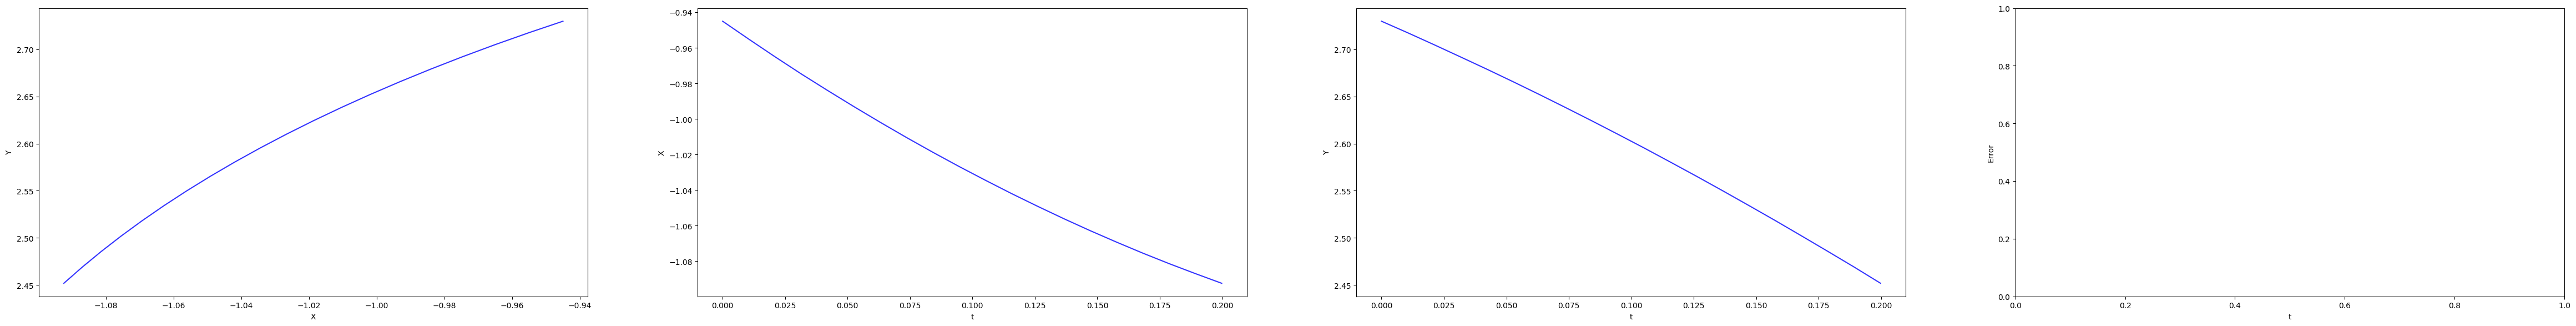

In [60]:
Xk, Uk = Xfull[:N_x, :].T, Xfull[N_x : N_x + N_u, :-1].T

poly = pk.observables.Polynomial(degree=2, include_bias=True)
RBF = pk.observables.RadialBasisFunction(
    rbf_type="thinplate",
    n_centers=10,
    centers=None,
    kernel_width=1.0,
    polyharmonic_coeff=1.0,
    include_state=True,
)
model = fitK(X_full=Xfull, train_ix=X_train_i, observables=RBF, svd_rank=-1)
if np.isnan(model.A.any()):
    print("NAN")
## Compare True and DMDc
Xh = plot_comparison(model, train_ix=X_train_i)
# Xh[0, :]


1
(100, 7) (100, 7) (100, 4)
False
Xkp: (100, 7)
False


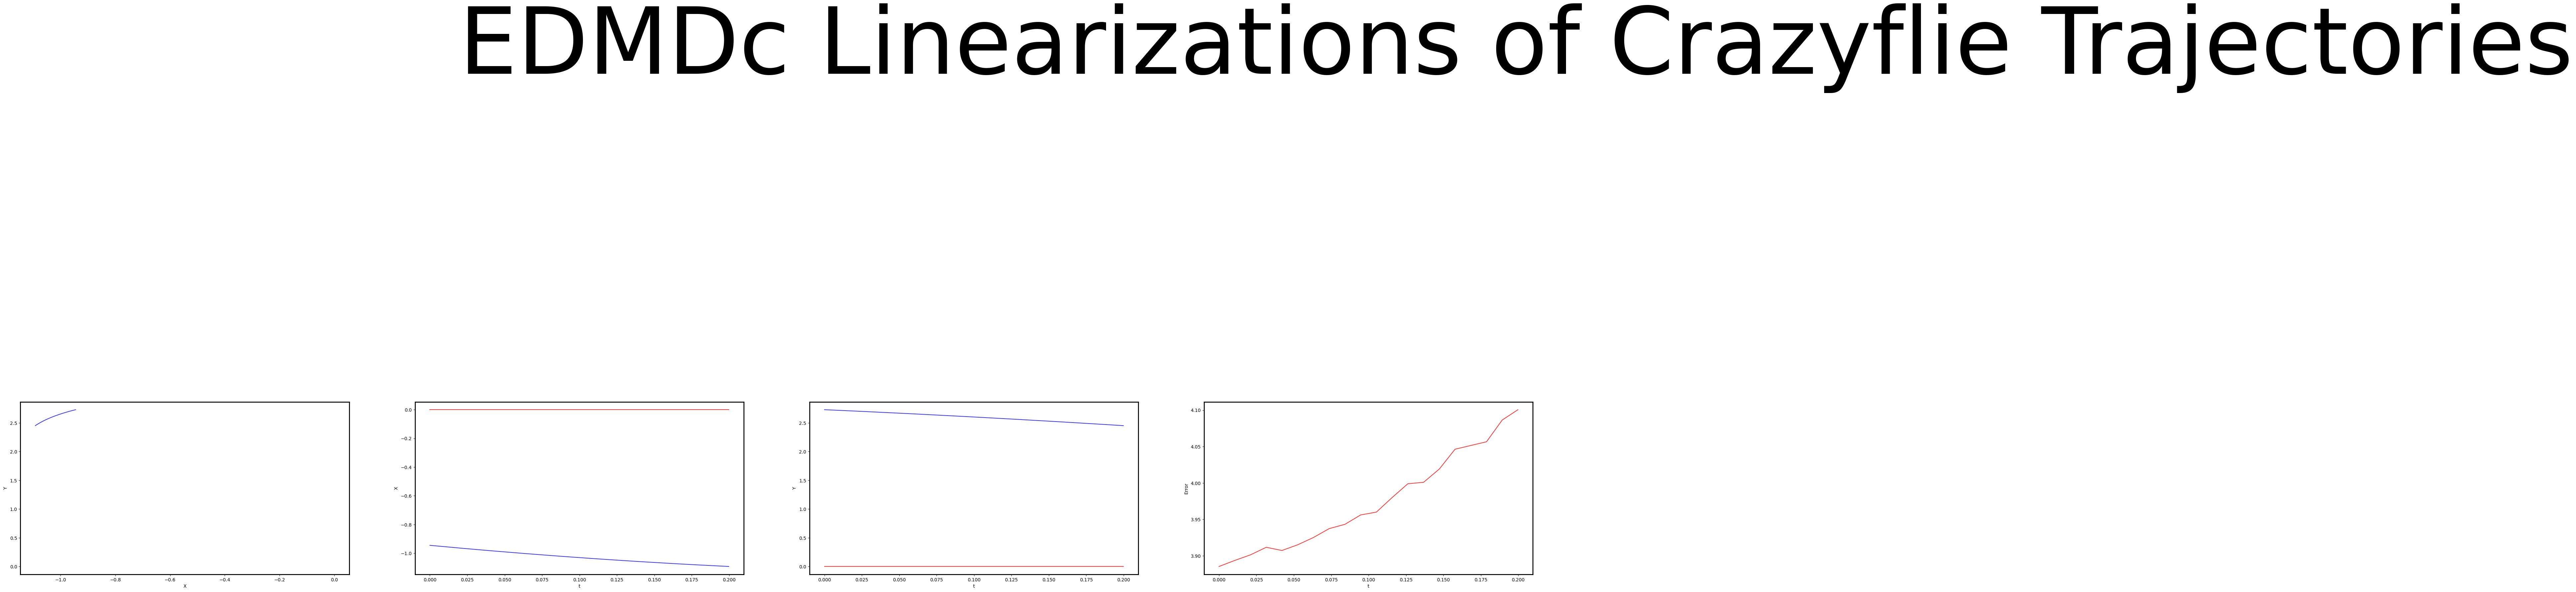

In [56]:
model = fitK(X_full=Xfull, train_ix=X_train_i, observables=poly, svd_rank=0)
if np.isnan(model.A.any()):
    print("NAN")
## Compare True and DMDc
Xh = plot_comparison(model, train_ix=X_train_i)

1
(100, 7) (100, 7) (100, 4)
False
Xkp: (100, 7)
False


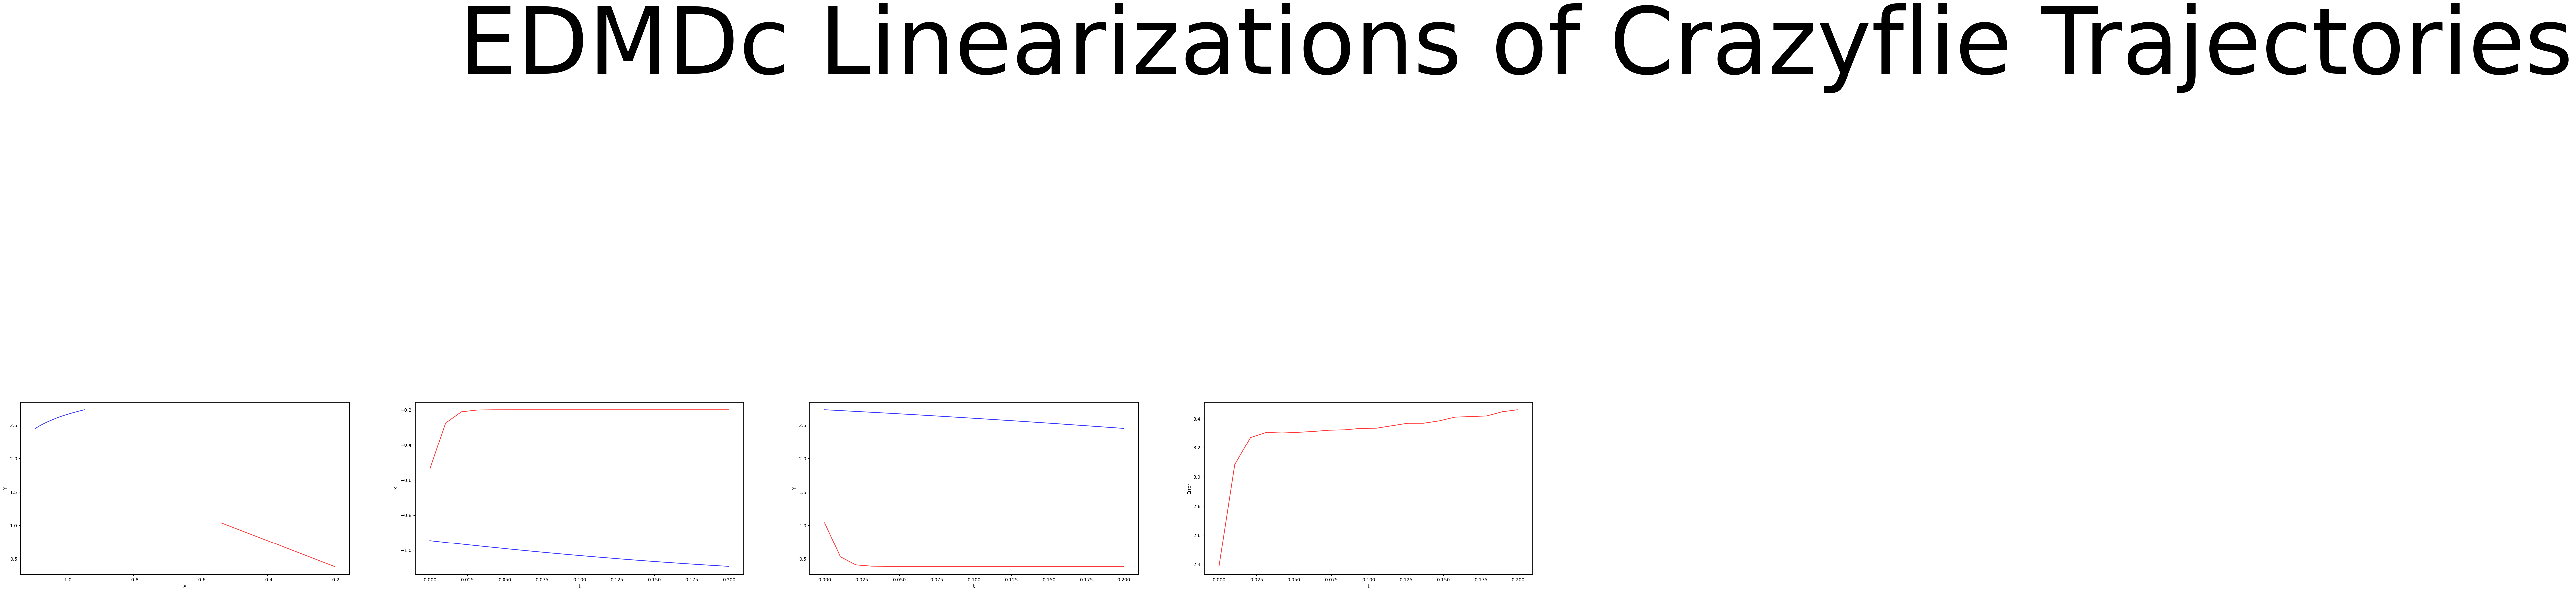

In [57]:
model = fitK(X_full=Xfull, train_ix=X_train_i, observables=poly, svd_rank=1)
if np.isnan(model.A.any()):
    print("NAN")
## Compare True and DMDc
Xh = plot_comparison(model, train_ix=X_train_i)

1
(100, 7) (100, 7) (100, 4)
False
Xkp: (100, 7)
False


ValueError: Input contains NaN.

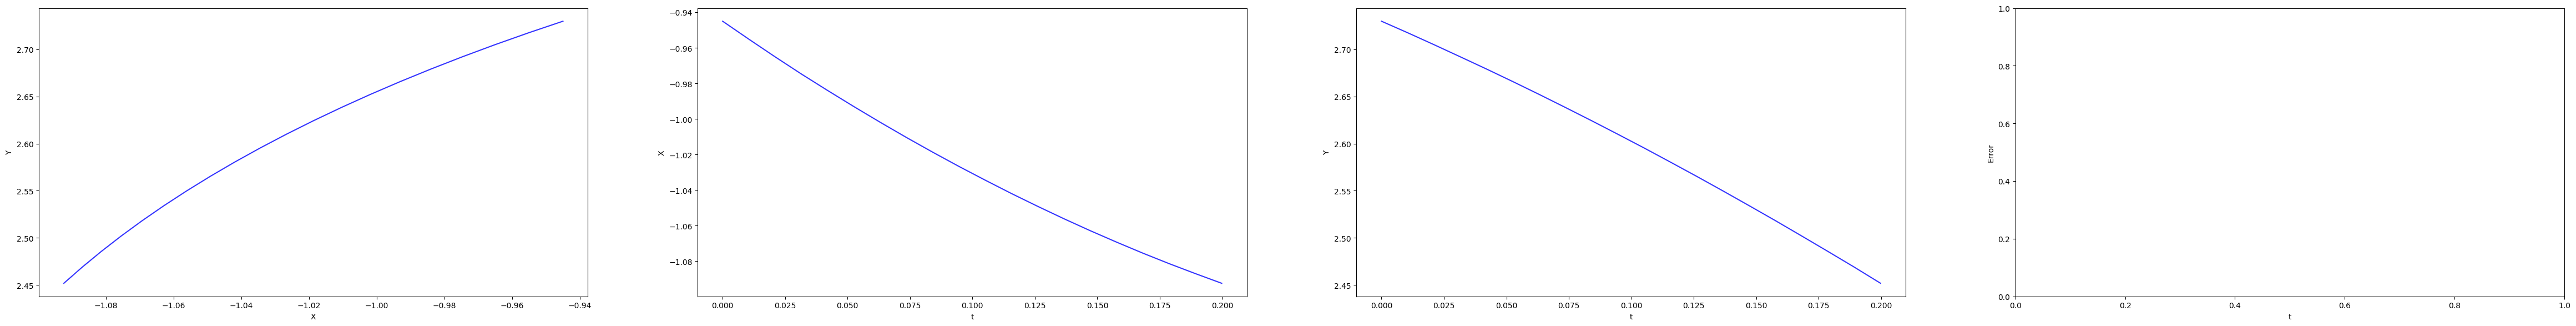

In [58]:
model = fitK(X_full=Xfull, train_ix=X_train_i, observables=poly, svd_rank=100)
if np.isnan(model.A.any()):
    print("NAN")
## Compare True and DMDc
Xh = plot_comparison(model, train_ix=X_train_i)

In [ ]:
Xh[0:7,10]

array([ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.20165869e-13,  0.00000000e+00])

In [ ]:
Xfull[0:7,10]

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-8.88744995e-13],
       [ 0.00000000e+00]])

In [ ]:
model.n_input_features_

7

In [ ]:
i=3
X = Xfull[:, :N_T, i]
Xh = model.simulate(X[:N_x, 0].reshape(1, -1), X[N_x:N_x+N_u, :].T, n_steps=10)

# use a try catch to get as far as possible, dont forget to plot in a common frame 

IndexError: index 3 is out of bounds for axis 2 with size 1

In [ ]:
sum(np.isnan(Xfull[:, :N_T, i][N_x:N_x+N_u, :].T))

array([0, 0])

In [ ]:
type(model.observables)

pykoopman.observables._radial_basis_functions.RadialBasisFunction

In [ ]:
model.observables.n_input_features_

4

In [ ]:
model.n_control_features_

2

In [ ]:
model.observables.transform(X[:N_x, 0].reshape(1, -1))

array([[1.35788263e+02, 2.48680458e+02, 0.00000000e+00, 8.72664626e-01,
        1.16905462e+05, 9.60316523e+04, 2.39019093e+03, 5.60972608e+04,
        1.33027145e+04, 9.82205545e+03, 7.13359681e+04, 7.56935679e+03,
        9.33758012e+04, 9.79009354e+04]])

In [ ]:
X[:N_x, 0].reshape(1, -1).shape

(1, 4)